# Thử ngồi code hết mấy cái CNN tìm hiểu được

##I. Dataset: CIFAR-10

In [40]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

In [41]:
#Load train and test data
train_data = torchvision.datasets.CIFAR10(root='dataset', train=True,
                                          download=True,
                                          transform=ToTensor(),
                                          target_transform=None)
test_data = torchvision.datasets.CIFAR10(root='dataset', train=False,
                                         download=True, transform=ToTensor(),
                                         target_transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
len(train_data), len(test_data)

(50000, 10000)

In [43]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

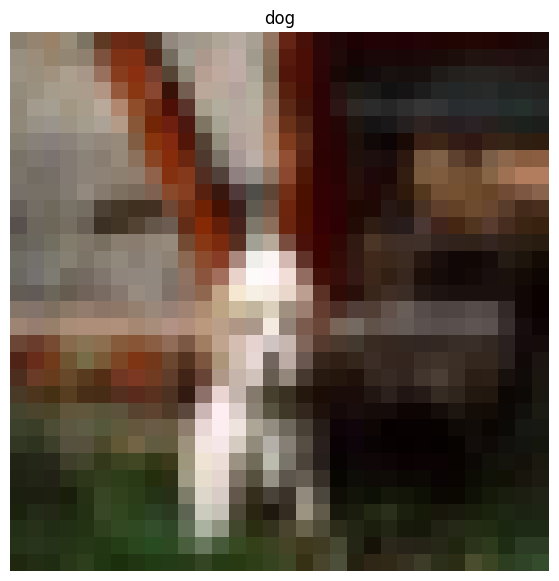

(32, 32, 3)

In [44]:
#Select random image
torch.manual_seed(12)
idx = torch.randint(0 , len(train_data), size  = [1])
image, label = train_data[idx]

#Get image class
class_names = train_data.classes

# Convert (C, H, W) to (H, W, C)
image = image.permute(1,2,0)
image = image.numpy()

#Show image
plt.figure(figsize=(10,7))
plt.axis('off')
plt.imshow(image)
plt.title(class_names[label])
plt.show()
image.shape

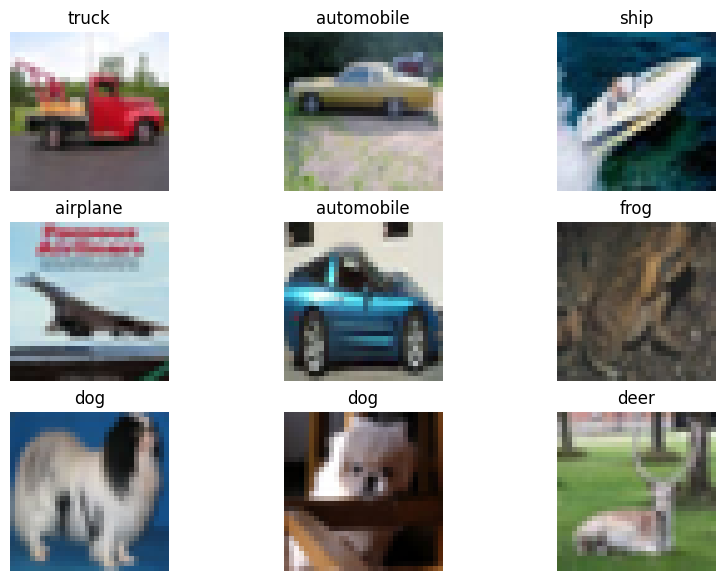

In [45]:
torch.manual_seed(20)
pic = plt.figure(figsize= (10,7))
rows = 3
columns = 3
for i in range(rows * columns):
  idx = torch.randint(0, len(train_data), size=[1])
  image, label = train_data[idx]

  image = image.permute(1,2,0)
  image = image.numpy()
  pic.add_subplot(rows, columns, i+ 1)
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis('off')
plt.show()

In [46]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)


##Train and test function

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [48]:
# Create directory to store models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok = True)

In [49]:
#Compute model's accuracy
def accuracy_fn(y_test, y_true):
  y_test_labels = torch.argmax(y_test, dim=1)
  correct  = (y_test_labels == y_true).sum().item()
  return round(correct / len(y_true) * 100, 4)

In [50]:
#Train function
def train_model(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device='cpu'):
  model.to(device)
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(torch.softmax(y_pred, dim = 1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss / len(train_dataloader), train_acc / len(train_dataloader)

In [51]:
#Evaluation function
def eval_model(model, test_dataloader, loss_fn, accuracy_fn, device='cpu'):
  model.to(device)
  test_loss, test_acc = 0, 0
  for X ,y in test_dataloader:
    X, y = X.to(device), y.to(device)
    model.eval()
    with torch.inference_mode():
      y_pred = model(X)
      test_loss += loss_fn(y_pred, y)
      test_acc += accuracy_fn(torch.softmax(y_pred, dim = 1), y)
  return test_loss/len(test_dataloader), test_acc / len(test_dataloader)

In [52]:
#Create a train-test loop, save the best model that have highest test accuracy during training
def train_test_model(model, train_dataloader,test_dataloader, loss_fn, accuracy_fn, optimizer,path, epochs = 3, device='cpu',best_acc = 0 ):
  torch.save(obj=model.state_dict(),f = path)
  train_acc_per_epoch = []
  test_acc_per_epoch = []
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_model(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device)
    test_loss, test_acc = eval_model(model, test_dataloader, loss_fn, accuracy_fn, device)
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(obj=model.state_dict(),f = path)
        print("model tốt đấy, lưu nhé")
    train_acc_per_epoch.append(train_acc)
    test_acc_per_epoch.append(test_acc)
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc} | Test loss: {test_loss} | Test_acc: {test_acc}")
  return train_acc_per_epoch, test_acc_per_epoch


In [53]:
def plot_trainning_progress(train, test):
  pic = plt.figure(figsize=(10,9))
  pic.add_subplot(1, 2, 1)
  plt.plot(train, label="Train accuracy")
  plt.legend()
  pic.add_subplot(1,2,2)
  plt.plot(test,label = "Test accuracy", c='orange')
  plt.legend()
  plt.show()

In [54]:
# Xavier initialization
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

##Some CNN

###Custom a model to test funtion :)


In [55]:
class CustomModel(nn.Module):
  def __init__(self, input, hidden, output):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input, out_channels=hidden,
                  kernel_size=3, stride=1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden, out_channels=hidden,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
    self.linear = nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features= hidden * 8 * 8, out_features=16), #in_features need to be finded
                                nn.ReLU(),
                                nn.Linear(in_features=16, out_features=10))
  def forward(self, X):
    X = self.conv_layer_1(X)
    # print(X.shape)
    X = self.conv_layer_2(X)
    # print(X.shape)
    return self.linear(X)


In [56]:
image , label = train_data[0]
custom_model_0 = CustomModel(image.shape[0], 10, len(class_names))

In [57]:
# Find in_features
with torch.inference_mode():
  custom_model_0(image.unsqueeze(dim=0))

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(custom_model_0.parameters(), lr = 0.1)

In [59]:
#Create save path
MODEL_NAME = "custom_model_0.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/custom_model_0.pth')

In [60]:
_, best_acc = eval_model(custom_model_0, test_dataloader, loss_fn, accuracy_fn, device )
train, test = train_test_model(custom_model_0, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                3, device, best_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

model tốt đấy, lưu nhé
Epoch: 0 | Train loss: 1.8240445852279663 | Train accuracy: 33.363323736404354 | Test loss: 1.6112346649169922 | Test_acc: 40.075878594249204
model tốt đấy, lưu nhé
Epoch: 1 | Train loss: 1.4432027339935303 | Train accuracy: 47.982645553422905 | Test loss: 1.446418285369873 | Test_acc: 47.48402555910543
model tốt đấy, lưu nhé
Epoch: 2 | Train loss: 1.3127321004867554 | Train accuracy: 53.20897312859885 | Test loss: 1.311866044998169 | Test_acc: 53.4944089456869


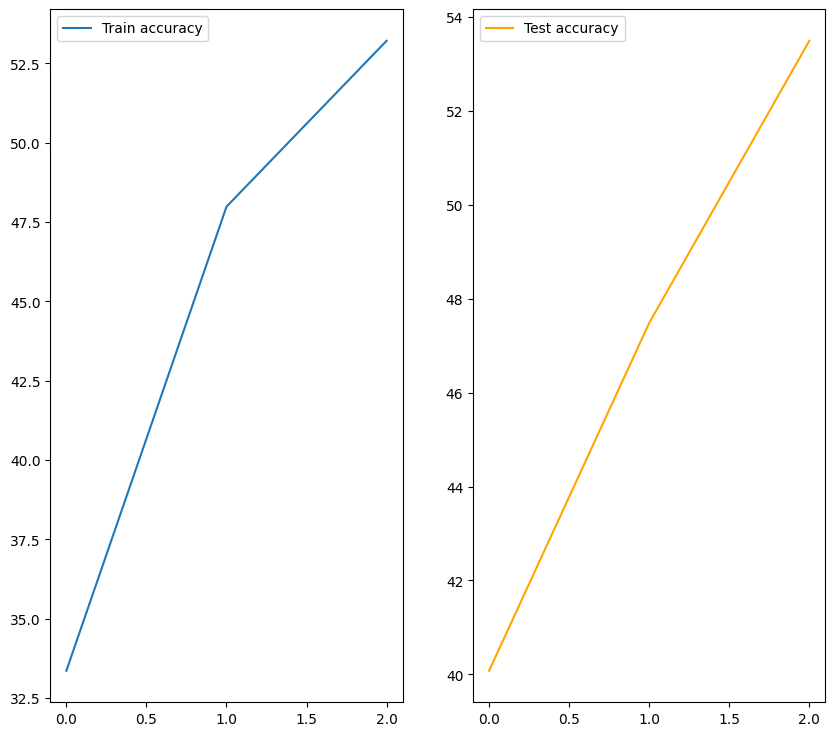

In [61]:
plot_trainning_progress(train, test)

In [62]:
custom_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH,weights_only=True))
eval_model(custom_model_0,test_dataloader,loss_fn,accuracy_fn,device)

(tensor(1.3119, device='cuda:0'), 53.4944089456869)

###LeNet
One of the first published CNNs. The model was introduced and named for Yann LeCun for a purpose of recognizing handwritten digits in images

LeNet consists two part: a convolutional encoder consisting of two convolutional layers and a dense block consisting of three fully connected layers.

The basic units in each convolutional block are convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Convolutionnal layer uses a 5 x 5 kernel. A pooling operation has 2 x 2 kernel and stride equal 2.

In dense block, it has three fully connected layers with 120, 84, and 10 outputs (10 is the class number so it doesn't fixed depends on the problem)

Information and LeNet architecture:
Dive into Deep Learning (https://d2l.ai/chapter_convolutional-neural-networks/lenet.html)

In [63]:


# Model class
class LeNet(nn.Module):
  def __init__(self, num_classes,lr=0.1):
    super().__init__()
    self.lr = lr
    self.conv_net = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels= 6, kernel_size= 5, padding = 2),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2),
        nn.Flatten(),)
    self.den_net = nn.Sequential(
        nn.Linear(576,120), nn.Sigmoid(),
        nn.Linear(120, 84), nn.Sigmoid(),
        nn.Linear(84, num_classes)
    )
  def forward(self, X):
    X = self.conv_net(X)
    return self.den_net(X)


In [64]:
lenet = LeNet(len(class_names))
lenet.apply(init_cnn)
lenet

LeNet(
  (conv_net): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (den_net): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr = lenet.lr)

In [66]:
#Create save path
MODEL_NAME = "LeNet.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/LeNet.pth')

In [67]:
_, best_acc = eval_model(lenet, test_dataloader, loss_fn, accuracy_fn, device)
best_acc

10.013977635782748

In [68]:
train, test = train_test_model(lenet, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                10, device, best_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.654566526412964 | Train accuracy: 9.99480166346769 | Test loss: 2.7126412391662598 | Test_acc: 9.984025559105431
Epoch: 1 | Train loss: 2.638673782348633 | Train accuracy: 9.902831094049905 | Test loss: 2.521603584289551 | Test_acc: 9.984025559105431
Epoch: 2 | Train loss: 2.654823064804077 | Train accuracy: 9.894833653230966 | Test loss: 2.536712408065796 | Test_acc: 9.994009584664537
Epoch: 3 | Train loss: 2.6559078693389893 | Train accuracy: 10.158749200255919 | Test loss: 2.573986291885376 | Test_acc: 10.013977635782748
Epoch: 4 | Train loss: 2.639108896255493 | Train accuracy: 10.01679462571977 | Test loss: 2.8132872581481934 | Test_acc: 9.994009584664537
Epoch: 5 | Train loss: 2.632134199142456 | Train accuracy: 9.90083173384517 | Test loss: 2.7454514503479004 | Test_acc: 9.994009584664537
Epoch: 6 | Train loss: 2.6421494483947754 | Train accuracy: 9.756877799104286 | Test loss: 2.5413553714752197 | Test_acc: 10.003993610223642
Epoch: 7 | Train loss: 2.66

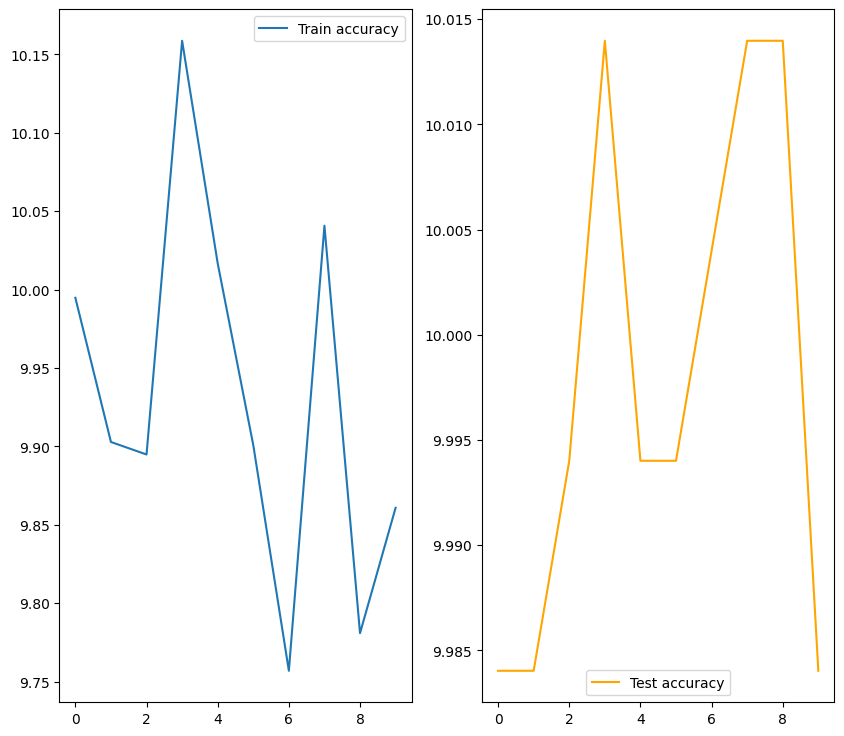

In [69]:
plot_trainning_progress(train, test)

In [70]:
lenet.load_state_dict(torch.load(MODEL_SAVE_PATH,weights_only=True))
eval_model(lenet,test_dataloader,loss_fn,accuracy_fn,device)

(tensor(2.4437, device='cuda:0'), 10.013977635782748)

###AlexNet
AlexNet was first designed for 224 x 224 image so maybe it's not suitable for this dataset which has 32 x 32 images. Therefore, I just created a AlexNet class here and did not train a model of that architecture

In [71]:
class AlexNet(nn.Module):
  def __init__(self, num_classes, lr = 0.1):
    super().__init__()
    self.net = nn.Sequential(
        nn.LazyConv2d(96, kernel_size=5 , stride=4), nn. ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LazyConv2d(96, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LazyConv2d(384, padding = 1), nn.ReLu(),
        nn.LazyConv2d(384, padding = 1), nn.ReLu(),
        nn.LazyConv2d(256, padding = 1), nn.ReLu(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLu(),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Linear(4096, num_classes)
    )
  def forward(self, X):
    return self.net(X)

###VGG

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Hàm tạo một khối VGG gồm num_convs lớp Conv2d và 1 lớp MaxPool2d
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        in_channels = out_channels  # Cập nhật số kênh đầu vào cho lớp tiếp theo
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Lớp VGG
class VGG(nn.Module):
    def __init__(self, arch, num_classes=10):
        super().__init__()

        # Tạo các khối convolutional
        in_channels = 3  # Ảnh đầu vào có 3 kênh (RGB)
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels  # Cập nhật số kênh đầu vào

        self.conv_layers = nn.Sequential(*conv_blks)

        # Lớp Fully Connected
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

        # Khởi tạo trọng số
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Kiến trúc VGG-16
vgg16_arch = [(2, 64), (2, 128), (3, 256), (3, 512), (3, 512)]
model_vgg = VGG(vgg16_arch, num_classes=10)
print(model_vgg)


VGG(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr = 0.1)

In [74]:
#Create save path
MODEL_NAME = "VGG.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/VGG.pth')

In [79]:
_, best_acc = eval_model(model_vgg, test_dataloader, loss_fn, accuracy_fn, device )
best_acc


77.14656549520767

In [80]:
train, test = train_test_model(model_vgg, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                15, device, best_acc)

  0%|          | 0/15 [00:00<?, ?it/s]

model tốt đấy, lưu nhé
Epoch: 0 | Train loss: 0.30462464690208435 | Train accuracy: 89.93322136916187 | Test loss: 0.7843090295791626 | Test_acc: 77.23642172523962
Epoch: 1 | Train loss: 0.2675229012966156 | Train accuracy: 91.22680742162508 | Test loss: 0.9602916240692139 | Test_acc: 74.85023961661342
Epoch: 2 | Train loss: 0.24001193046569824 | Train accuracy: 92.21849008317338 | Test loss: 0.8942215442657471 | Test_acc: 76.75718849840256
model tốt đấy, lưu nhé
Epoch: 3 | Train loss: 0.2016143947839737 | Train accuracy: 93.52207293666027 | Test loss: 0.8680877089500427 | Test_acc: 77.67571884984025
Epoch: 4 | Train loss: 0.19297011196613312 | Train accuracy: 93.9239443378119 | Test loss: 0.894417941570282 | Test_acc: 76.74720447284345
Epoch: 5 | Train loss: 0.19029980897903442 | Train accuracy: 94.0579014715291 | Test loss: 0.9076532125473022 | Test_acc: 77.03674121405751
model tốt đấy, lưu nhé
Epoch: 6 | Train loss: 0.15926946699619293 | Train accuracy: 94.96561100447856 | Test loss

In [81]:
model_vgg.load_state_dict(torch.load(MODEL_SAVE_PATH,weights_only=True))
eval_model(model_vgg,test_dataloader,loss_fn,accuracy_fn,device)

(tensor(0.8423, device='cuda:0'), 78.8738019169329)